loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
COCO categories for damages: 
damage

COCO supercategories for damages: 
part

COCO categories for parts: 
headlamp, rear_bumper, door, hood, front_bumper

COCO supercategories for parts: 
part

2 image id was selected at random from the [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] list
Image details 
 {'coco_url': '', 'date_captured': '2020-07-14 09:59:34.190485', 'file_name': '24.jpg', 'flickr_url': '', 'height': 1024, 'id': 2, 'license': 1, 'width': 1024}


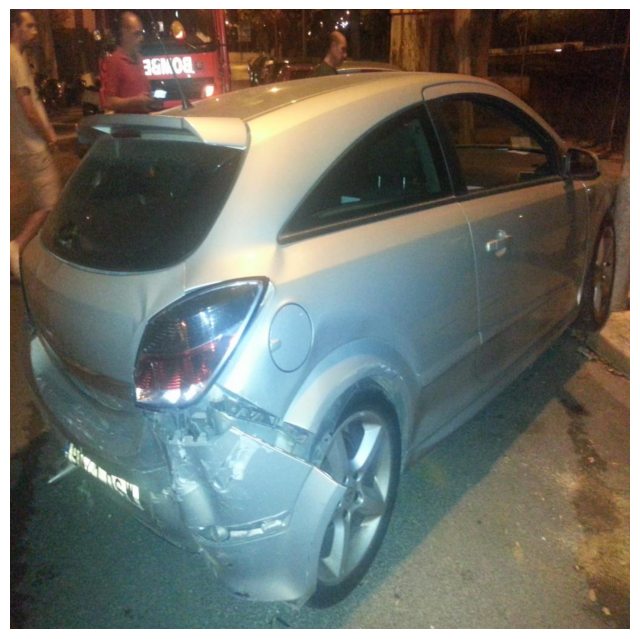

Parts are: ['rear_bumper', 'headlamp', 'door']


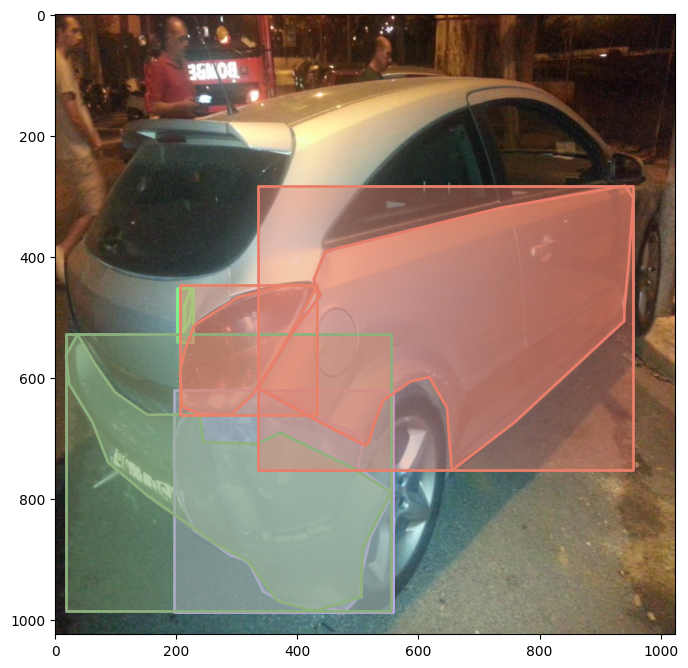

In [1]:



from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

# For visualization
import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image

dataDir='./Dataset/val'
dataType='COCO_val_annos'
mul_dataType='COCO_mul_val_annos'
annFile='{}/{}.json'.format(dataDir,dataType)
mul_annFile='{}/{}.json'.format(dataDir,mul_dataType)
img_dir = "./Dataset/img"

coco=COCO(annFile)
mul_coco=COCO(mul_annFile)


#Single Class #Damage dataset
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories for damages: \n{}\n'.format(', '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories for damages: \n{}\n'.format(', '.join(nms)))

#Multi Class #Parts dataset

mul_cats = mul_coco.loadCats(mul_coco.getCatIds())
mul_nms=[cat['name'] for cat in mul_cats]
print('COCO categories for parts: \n{}\n'.format(', '.join(mul_nms)))

mul_nms = set([mul_cat['supercategory'] for mul_cat in mul_cats])
print('COCO supercategories for parts: \n{}\n'.format(', '.join(mul_nms)))


# get all images containing 'damage' category, select one at random
catIds = coco.getCatIds(catNms=['damage']);
imgIds = coco.getImgIds(catIds=catIds );

random_img_id = random.choice(imgIds)
print("{} image id was selected at random from the {} list".format(random_img_id, imgIds))

# Load the image
imgId = coco.getImgIds(imgIds = [random_img_id])
img = coco.loadImgs(imgId)[0]
print("Image details \n",img)


I = io.imread(img_dir + '/' + img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()


#get damage annotations
annIds = coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = coco.loadAnns(annIds)

#Plot damages
plt.imshow(I)
plt.axis('on')
coco.showAnns(anns, draw_bbox=True )


#get parts annotations
mul_annIds = mul_coco.getAnnIds(imgIds=imgId,iscrowd=None)
mul_anns = mul_coco.loadAnns(mul_annIds)

# Create a dictionary between category_id and category name
category_map = dict()

for ele in list(mul_coco.cats.values()):
    category_map.update({ele['id']:ele['name']})

category_map

{1: 'headlamp', 2: 'rear_bumper', 3: 'door', 4: 'hood', 5: 'front_bumper'}

#Create a list of parts in the image
parts = []
for region in mul_anns:
    parts.append(category_map[region['category_id']])

print("Parts are:", parts) 

#Plot Parts
I = io.imread(img_dir + '/' + img['file_name'])
plt.imshow(I)
plt.axis('on')
mul_coco.showAnns(mul_anns, draw_bbox=True )



pip install torch==2.0.0+cu118 torchvision==0.15.0+cu118 torchaudio==2.0.0 -f https://download.pytorch.org/whl/torch_stable.html


In [2]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())


2.0.0+cu118 True


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator
from detectron2.data import build_detection_test_loader

# Set base params
plt.rcParams["figure.figsize"] = [16, 9]

# Define paths
dataset_dir = "./Dataset/"
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"

# Register COCO instances
from detectron2.data.datasets import register_coco_instances
register_coco_instances("car_dataset_train", {}, os.path.join(dataset_dir, train_dir, "COCO_train_annos.json"), os.path.join(dataset_dir, img_dir))
register_coco_instances("car_dataset_val", {}, os.path.join(dataset_dir, val_dir, "COCO_val_annos.json"), os.path.join(dataset_dir, img_dir))

dataset_dicts = DatasetCatalog.get("car_dataset_train")
metadata_dicts = MetadataCatalog.get("car_dataset_train")

# Define a custom Trainer with COCO evaluation
class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("car_dataset_train",)
cfg.DATASETS.TEST = ("car_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  
cfg.MODEL.RETINANET.NUM_CLASSES = 1 
cfg.OUTPUT_DIR = "./output"

# Solver settings
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0005  
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2000  
cfg.SOLVER.STEPS = (1500, 1800)  
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WEIGHT_DECAY = 0.0001 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 

# Data Augmentation (Detectron2’s built-in)
cfg.INPUT.MIN_SIZE_TRAIN = (640, 672, 704, 736, 768, 800)
cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING = "choice"  
cfg.INPUT.RANDOM_FLIP = "horizontal"  
cfg.INPUT.BRIGHTNESS = 0.8, 1.2
cfg.INPUT.CONTRAST = 0.8, 1.2
cfg.INPUT.SATURATION = 0.8, 1.2
cfg.TEST.EVAL_PERIOD = 200  

import shutil
if os.path.exists(cfg.OUTPUT_DIR):
    shutil.rmtree(cfg.OUTPUT_DIR)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Train the model
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

evaluator = COCOEvaluator("car_dataset_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "car_dataset_val")

# Use the trainer's test method for evaluation
results = trainer.test(cfg, trainer.model, evaluators=[evaluator])
print(results)


[11/11 11:43:46 d2.data.datasets.coco]: Loaded 59 images in COCO format from ./Dataset/train/COCO_train_annos.json
[11/11 11:43:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padd

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[11/11 11:43:46 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\walte\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/11 11:44:00 d2.utils.events]:  eta: 0:17:34  iter: 19  total_loss: 2.042  loss_cls: 0.7068  loss_box_reg: 0.3482  loss_mask: 0.6909  loss_rpn_cls: 0.161  loss_rpn_loc: 0.02163    time: 0.5247  last_time: 0.5304  data_time: 0.1164  last_data_time: 0.0029   lr: 9.9905e-06  max_mem: 3098M
[11/11 11:44:12 d2.utils.events]:  eta: 0:17:29  iter: 39  total_loss: 1.938  loss_cls: 0.604  loss_box_reg: 0.3796  loss_mask: 0.6883  loss_rpn_cls: 0.1899  loss_rpn_loc: 0.02316    time: 0.5271  last_time: 0.5305  data_time: 0.0027  last_data_time: 0.0019   lr: 1.998e-05  max_mem: 3098M
[11/11 11:44:23 d2.utils.events]:  eta: 0:17:16  iter: 59  total_loss: 1.708  loss_cls: 0.4751  loss_box_reg: 0.398  loss_mask: 0.6794  loss_rpn_cls: 0.1674  loss_rpn_loc: 0.02145    time: 0.5260  last_time: 0.5156  data_time: 0.0027  last_data_time: 0.0022   lr: 2.997e-05  max_mem: 3098M
[11/11 11:44:33 d2.utils.events]:  eta: 0:17:02  iter: 79  total_loss: 1.61  loss_cls: 0.4051  loss_box_reg: 0.356  loss_mask: 0.

Load

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf
from tensorboard.backend.event_processing import event_accumulator

def smooth(scalars, weight=0.6):
    """Smooths the scalar values"""
    last = scalars[0]
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

def plot(logdir: str, savedir: str, smoothing: float = 0.6, no_title=False, no_legend=False, no_axis_labels=False):

    assert 0 <= smoothing <= 1, 'Smoothing value should be in [0,1]'

    plots = []

    sns.set(style="darkgrid")
    sns.set_context("paper")

    # Collect data
    scalars_info = {}
    for root, dirs, files in os.walk(logdir):
        for event_file in [x for x in files if 'tfevents' in x]:
            event_path = os.path.join(root, event_file)

            # Use tensorboard's event accumulator to read event data
            acc = event_accumulator.EventAccumulator(event_path)
            acc.Reload()

            # Only support scalar data now
            scalar_list = acc.Tags()['scalars']
            for tag in scalar_list:
                x = [s.step for s in acc.Scalars(tag)]
                y = [s.value for s in acc.Scalars(tag)]
                data = {'x': x, 'y': y, 'legend': root.split(logdir)[1][1:] if root != logdir else None}
                if tag not in scalars_info:
                    scalars_info[tag] = [data]
                else:
                    scalars_info[tag].append(data)

    # Process each tag's data
    for tag, tag_data in scalars_info.items():
        _split = tag.split('/')
        if len(_split) <= 1:
            _path = os.path.join(savedir, 'seaborn')
            _name = _split[0]
        else:
            _path = os.path.join(savedir, 'seaborn', _split[0])
            _name = ''.join(_split[1:])

        os.makedirs(_path, exist_ok=True)

        color_list = list(sns.color_palette(palette='dark', n_colors=len(tag_data)))[::-1]
        for data in tag_data:
            x, y = data['x'], data['y']
            y_smooth = smooth(y, weight=smoothing)
            current_color = color_list.pop()
            
            # Ensure sns.lineplot receives keyword arguments
            _plt = sns.lineplot(x=x, y=y, color=colors.to_rgba(current_color, alpha=0.4))
            if not no_legend:
                _plt = sns.lineplot(x=x, y=y_smooth, label=data['legend'], color=current_color)
            else:
                _plt = sns.lineplot(x=x, y=y_smooth, color=current_color)

        if not no_axis_labels:
            _plt.set(xlabel='x', ylabel='y')
        if not no_title:
            _plt.set_title(_name.capitalize())
        
        plot_path = os.path.join(_path, _name + '.png')
        plots.append(plot_path)
        plt.savefig(plot_path)
        plt.clf()  # Clear the plot for the next one

    return plots


In [5]:
plots = plot(logdir= './output', savedir= './')

<Figure size 1600x900 with 0 Axes>

In [6]:
plots

['./seaborn\\rpn\\num_pos_anchors.png',
 './seaborn\\rpn\\num_neg_anchors.png',
 './seaborn\\roi_head\\num_fg_samples.png',
 './seaborn\\roi_head\\num_bg_samples.png',
 './seaborn\\fast_rcnn\\cls_accuracy.png',
 './seaborn\\fast_rcnn\\fg_cls_accuracy.png',
 './seaborn\\fast_rcnn\\false_negative.png',
 './seaborn\\mask_rcnn\\accuracy.png',
 './seaborn\\mask_rcnn\\false_positive.png',
 './seaborn\\mask_rcnn\\false_negative.png',
 './seaborn\\rank_data_time.png',
 './seaborn\\data_time.png',
 './seaborn\\total_loss.png',
 './seaborn\\loss_cls.png',
 './seaborn\\loss_box_reg.png',
 './seaborn\\loss_mask.png',
 './seaborn\\loss_rpn_cls.png',
 './seaborn\\loss_rpn_loc.png',
 './seaborn\\lr.png',
 './seaborn\\time.png',
 './seaborn\\eta_seconds.png',
 './seaborn\\bbox\\AP.png',
 './seaborn\\bbox\\AP50.png',
 './seaborn\\bbox\\AP75.png',
 './seaborn\\bbox\\APs.png',
 './seaborn\\bbox\\APm.png',
 './seaborn\\bbox\\APl.png',
 './seaborn\\segm\\AP.png',
 './seaborn\\segm\\AP50.png',
 './seaborn\\

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

# Your existing figure setup and image loading code
my_dpi = 1000
fig, ax = plt.subplots(1, 1, figsize=(12, 10), dpi=my_dpi)  # Single axis for all images

# Plot each image at specific positions within the main figure
image_paths = [
    './seaborn/total_loss.png',
    './seaborn/bbox/AP.png',
    './seaborn/segm/AP.png',
    './seaborn/fast_rcnn/cls_accuracy.png'
]

titles = [
    'Total Loss',
    'Bounding Box Average Precision',
    'Segmentation Average Precision',
    'Class accuracy'
]

# Create a 2x2 grid to fit all the images
ax_arr = fig.subplots(2, 2)  # Create 2 rows, 2 columns grid for all images
ax_arr = ax_arr.flatten()  # Flatten to make indexing easier

for i, (image_path, title) in enumerate(zip(image_paths, titles)):
    ax_arr[i].set_title(title, fontsize=12)
    ax_arr[i].set_xticks([])
    ax_arr[i].set_yticks([])
    ax_arr[i].imshow(Image.open(image_path))

# Save the figure to a file
fig.savefig('./output/combined_images.png', bbox_inches='tight', pad_inches=0.1)

# Optionally, display the saved figure to confirm it looks as expected
plt.show()


eval

In [8]:


evaluator = COCOEvaluator("car_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "car_dataset_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))



[11/11 12:02:43 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [11/11 12:02:43 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/11 12:02:43 d2.data.datasets.coco]: Loaded 11 images in COCO format from ./Dataset/val/COCO_val_annos.json
[11/11 12:02:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/11 12:02:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/11 12:02:43 d2.data.common]: Serializing 11 elements to byte tensors and concatenating them all ...
[11/11 12:02:43 d2.data.common]: Serialized dataset takes 0.01 MiB


NameError: name 'inference_on_dataset' is not defined

In [ ]:


cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("car_dataset_val", )
predictor = DefaultPredictor(cfg)



[11/11 09:52:53 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...


In [ ]:
val_dataset_dicts = DatasetCatalog.get("car_dataset_val")
val_metadata_dicts = MetadataCatalog.get("car_dataset_val")

[11/11 09:52:56 d2.data.datasets.coco]: Loaded 11 images in COCO format from ./Dataset/val/COCO_val_annos.json


[11/11 12:03:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
Image ./Dataset/img/1.jpg loaded successfully.
Image ./Dataset/img/2.jpg loaded successfully.
Image ./Dataset/img/3.jpg loaded successfully.
Image ./Dataset/img/4.jpg loaded successfully.
Image ./Dataset/img/5.jpg loaded successfully.
Image ./Dataset/img/6.jpg loaded successfully.
Image ./Dataset/img/7.jpg loaded successfully.
Image ./Dataset/img/8.jpg loaded successfully.
Image ./Dataset/img/9.jpg loaded successfully.
Image ./Dataset/img/10.jpg loaded successfully.
Error loading image ./Dataset/img/11.jpg!
Error loading image ./Dataset/img/12.jpg!
Image ./Dataset/img/13.jpg loaded successfully.
Image ./Dataset/img/14.jpg loaded successfully.
Image ./Dataset/img/15.jpg loaded successfully.
Image ./Dataset/img/16.jpg loaded successfully.
Image ./Dataset/img/17.jpg loaded successfully.
Image ./Dataset/img/18.jpg loaded successfully.
Image ./Dataset/img/19.jpg loaded succ

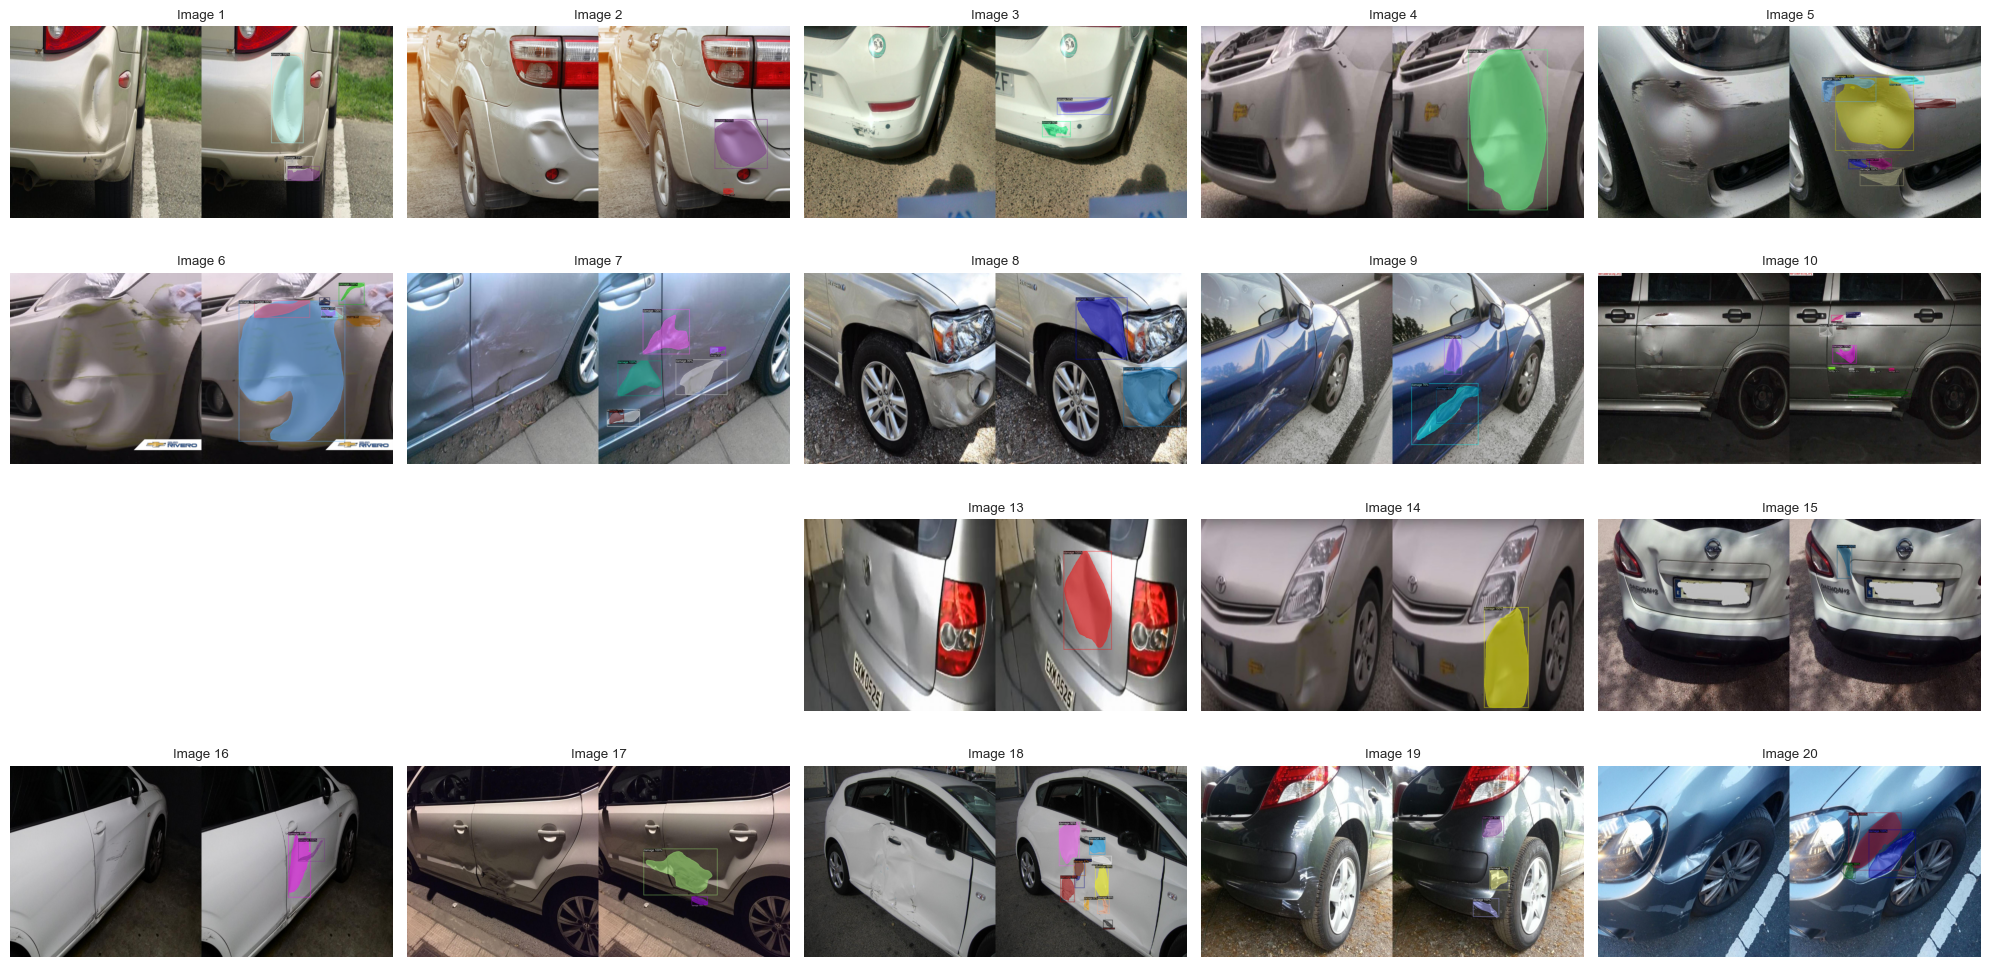

In [9]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
import matplotlib.pyplot as plt

# Function to load the trained model
def load_trained_model(cfg, weights_path):
    # Merge the config from the model that was used for training
    cfg.MODEL.WEIGHTS = weights_path  # Point to the path where the final model weights are stored
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # Set the threshold for making predictions (lowered threshold)
    cfg.MODEL.DEVICE = "cpu"  # Use CPU for inference instead of GPU
    predictor = DefaultPredictor(cfg)
    return predictor

# Set up the config (this should match the config used during training)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("car_dataset_train",)
cfg.DATASETS.TEST = ("car_dataset_val",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Set the correct number of classes (damage)
cfg.MODEL.WEIGHTS = "./output/model_final.pth"  # Path to the final model weights after training

# Load the trained model
predictor = load_trained_model(cfg, cfg.MODEL.WEIGHTS)

# Loop through images 1.jpg to 20.jpg
image_paths = [f"./Dataset/img/{i}.jpg" for i in range(1, 21)]

# Create a subplot for displaying multiple images
plt.figure(figsize=(20, 10))

# Iterate through each image
for idx, image_path in enumerate(image_paths, 1):
    # Read the image
    img = cv2.imread(image_path)

    # Check if the image was loaded correctly
    if img is None:
        print(f"Error loading image {image_path}!")
        continue
    else:
        print(f"Image {image_path} loaded successfully.")

    # Make predictions
    outputs = predictor(img)

    # Check if any instances were predicted
    if "instances" in outputs and len(outputs["instances"]) > 0:
        # Access the instances object
        instances = outputs["instances"].to("cpu")

        # Visualize the predictions on the original image
        v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
        v = v.draw_instance_predictions(instances)

        # Get the image with highlighted damage areas
        highlighted_img = v.get_image()[:, :, ::-1]

        # Ensure both images have the same size and color channels
        if highlighted_img.shape != img.shape:
            # Resize the highlighted image to match the original image size
            highlighted_img = cv2.resize(highlighted_img, (img.shape[1], img.shape[0]))

        # Create a side-by-side comparison
        comparison = cv2.hconcat([img, highlighted_img])

        # Display the comparison in the notebook using matplotlib
        plt.subplot(4, 5, idx)  # Arrange images in a 4x5 grid (you can adjust the number of rows/columns)
        plt.imshow(cv2.cvtColor(comparison, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        plt.axis('off')  # Hide axis
        plt.title(f"Image {idx}")
    else:
        print(f"No predictions made for image {image_path}.")

# Show the grid of images
plt.tight_layout()
plt.show()
